In [1]:
!pip install -q diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from diffusers import DDPMScheduler , UNet2DModel
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device  : {device}")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Using device  : cuda


# Data

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
labels: tensor([9, 4, 9, 5, 9, 0, 7, 4])


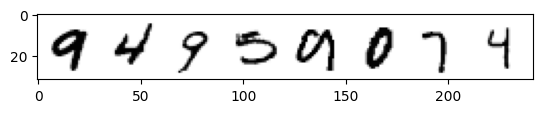

In [5]:
x, y = next(iter(train_dataloader))
print(f"Input shape: {x.shape}")
print(f"labels: {y}")
plt.imshow(torchvision.utils.make_grid(x)[0] , cmap="Greys")

# The Corruption Process
Pretend you haven’t read any diffusion model papers, but you know the process involves adding noise. How would you do it?

We probably want an easy way to control the amount of corruption. So what if we take in a parameter for the amount of noise to add, and then we do:
`noise = torch.rand_like(x)`

`noisy_x = (1-amount)*x + amount*noise`

If amount = 0, we get back the input without any changes. If amount gets up to 1, we get back noise with no trace of the input x. By mixing the input with noise this way, we keep the output in the same range (0 to 1).

We can implement this fairly easily (just watch the shapes so you don’t get burnt by broadcasting rules):

In [6]:
def corrupt(x, amount):
  """Corrupt the input 'x' by misxing it with noise according to 'amount'"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
  return x*(1- amount) + noise*amount

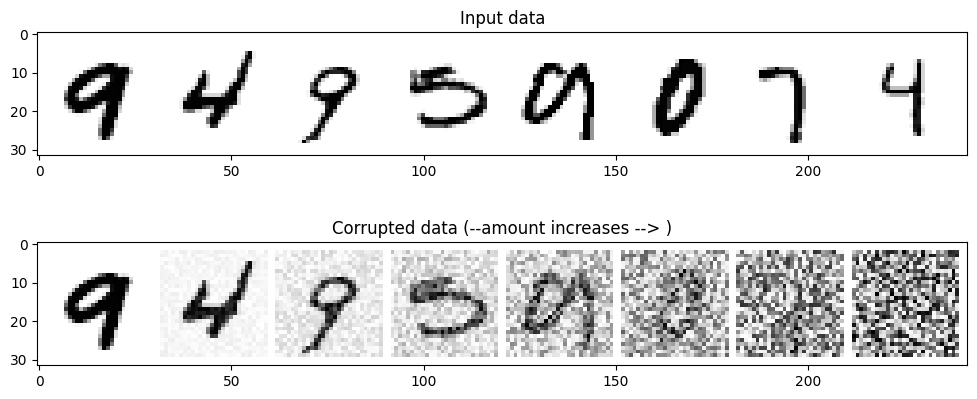

In [7]:
fig , axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding Noise
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

# Plotting the noise amount
axs[1].set_title("Corrupted data (--amount increases --> )")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")


# The Model

We’d like a model that takes in a 28px noisy images and outputs a prediction of the same shape. A popular choice here is an architecture called a UNet. Originally invented for segmentation tasks in medical imagery, a UNet consists of a ‘constricting path’ through which data is compressed down and an ‘expanding path’ through which it expands back up to the original dimension (similar to an autoencoder) but also features skip connections that allow for information and gradients to flow across at different levels.


Some UNets feature complex blocks at each stage, but for this toy demo we’ll build a minimal example that takes in a one-channel image and passes it through three convolutional layers on the down path (the down_layers in the diagram and code) and three on the up path, with skip connections between the down and up layers. We’ll use max pooling for downsampling and nn.Upsample for upsampling rather than relying on learnable layers like more complex UNets. Here is the rough architecture showing the number of channels in the output of each layer:

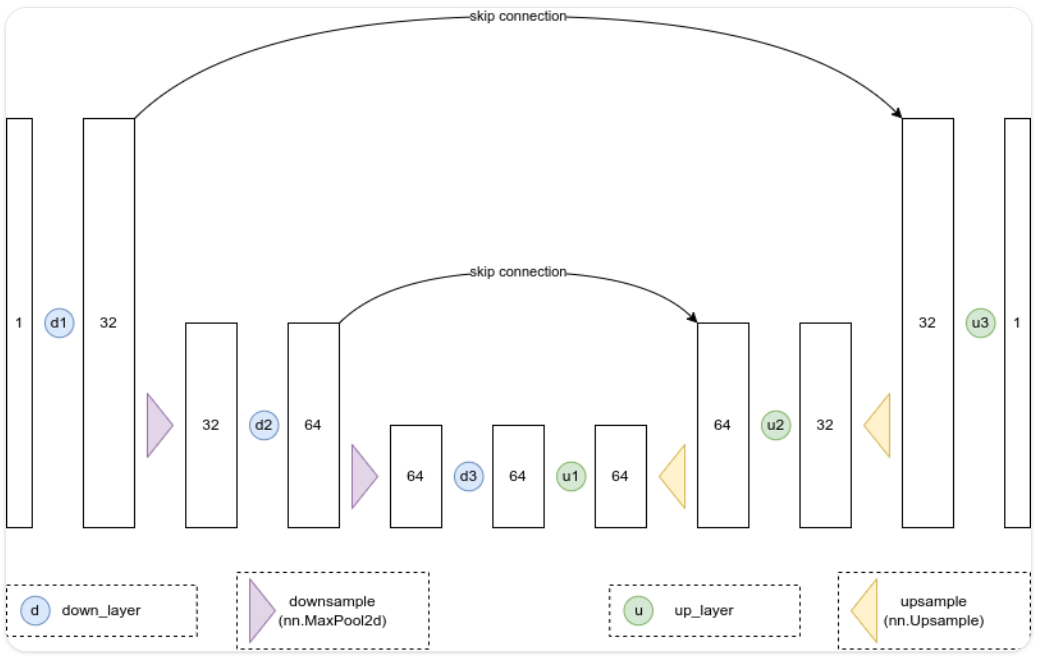

In [8]:
class BasicUNet(nn.Module):
  def __init__(self, in_channels=1 , out_channels=1):
    super().__init__()
    self.down_layers = torch.nn.ModuleList(
        [
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2)
        ]
    )
    self.up_layers = torch.nn.ModuleList(
        [
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
        ]
    )

    self.act = nn.SiLU()   # The activation function
    self.downscale = nn.MaxPool2d(2)
    self.upscale = nn.Upsample(scale_factor=2)

  def forward(self, x):
    h = []
    for i, layer in enumerate(self.down_layers):
      x = self.act(layer(x))
      if i < 2:
        h.append(x)
        x = self.downscale(x)

    for i, layer in enumerate(self.up_layers):
      if i > 0:
        x = self.upscale(x)
        x += h.pop()
      x = self.act(layer(x))
    return x

We can verify that the output shape is the same as the input, as we expect:

In [9]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

**This network has just over 300,000 parameters:**

In [10]:
sum([p.numel() for p in net.parameters()])

309057

Training the network
So what should the model do, exactly? Again, there are various takes on this but for this demo let’s pick a simple framing: given a corrupted input noisy_x the model should output its best guess for what the original x looks like. We will compare this to the actual value via the mean squared error.

We can now have a go at training the network.

Get a batch of data
Corrupt it by random amounts
Feed it through the model
Compare the model predictions with the clean images to calculate our loss
Update the model’s parameters accordingly.
Feel free to modify this and see if you can get it working better!

Finished epoch 0. Average loss for this epoch: 0.026148
Finished epoch 1. Average loss for this epoch: 0.020103
Finished epoch 2. Average loss for this epoch: 0.018436


(0.0, 0.1)

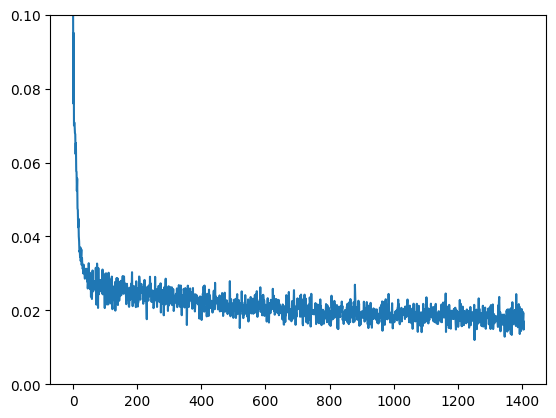

In [11]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr =1e-3)

# keeping a record of losses for later viewing
losses = []

for epoch in range(n_epochs):
  for x , y , in train_dataloader:
    x = x.to(device)
    noise_amount = torch.rand(x.shape[0]).to(device)
    noisy_x = corrupt(x, noise_amount)

    # Get the Model prediction
    pred = net(noisy_x)

    # Calculate the loss
    loss = loss_fn(pred, x)

    # Back prop and update the params
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Store the loss for later
    losses.append(loss.item())

  # Print out the averge of the loss values for this epoch
  avg_loss =  sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
  print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")


# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

We can try to see what the model predictions look like by grabbing a batch of data, corrupting it by different amounts and then seeing the models predictions:

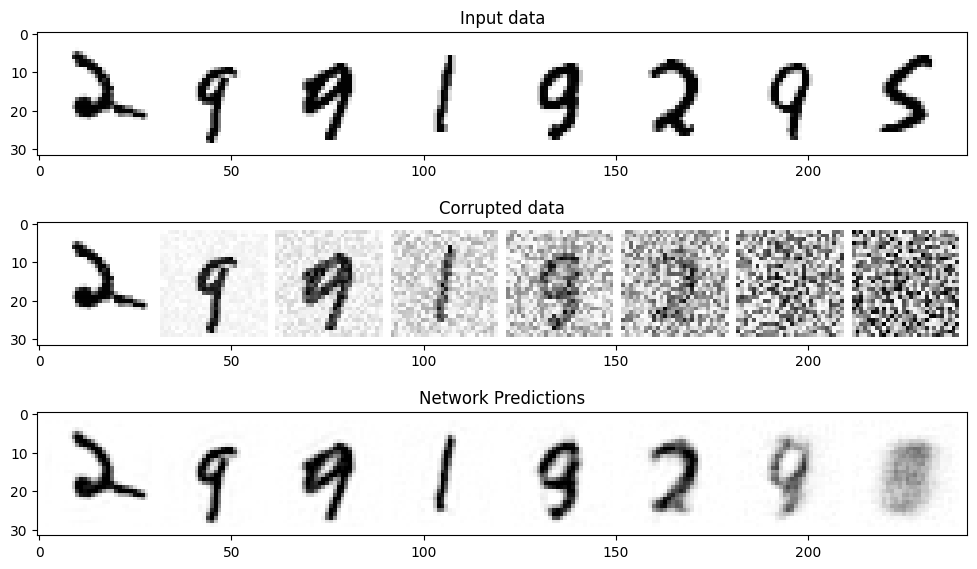

In [12]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]

# Corrupt with the range of amounts
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()


# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")





You can see that for the lower amounts the predictions are pretty good! But as the level gets very high there is less for the model to work with, and by the time we get to amount=1 it outputs a blurry mess close to the mean of the dataset to try and hedge its bets on what the output might look like…

# Sampling

If our predictions at high noise levels aren’t very good, how do we generate images?

Well, what if we start from random noise, look at the model predictions but then only move a small amount towards that prediction - say, 20% of the way there. Now we have a very noisy image in which there is perhaps a hint of structure, which we can feed into the model to get a new prediction. The hope is that this new prediction is slightly better than the first one (since our starting point is slightly less noisy) and so we can take another small step with this new, better prediction.

Repeat a few times and (if all goes well) we get an image out! Here is that process illustrated over just 5 steps, visualizing the model input (left) and the predicted denoised images (right) at each stage. Note that even though the model predicts the denoised image even at step 1, we only move x part of the way there. Over a few steps the structures appear and are refined, until we get our final outputs.

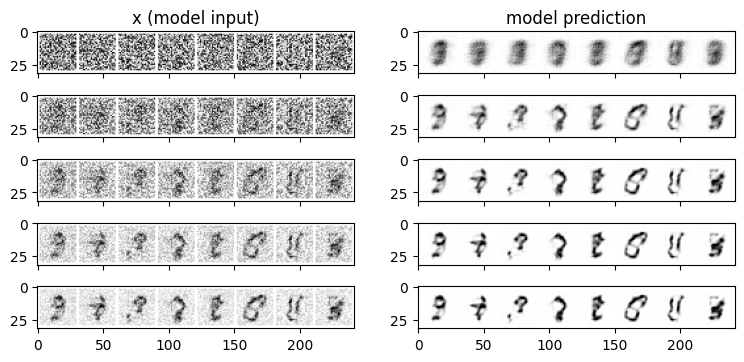

In [13]:
n_steps = 5
x = torch.rand(8, 1 , 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):

    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1/(n_steps - 1)
    x = x*(1- mix_factor) + pred*mix_factor
    step_history.append(x.detach().cpu())



fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

We can split the process up into more steps, and hope for better images that way:

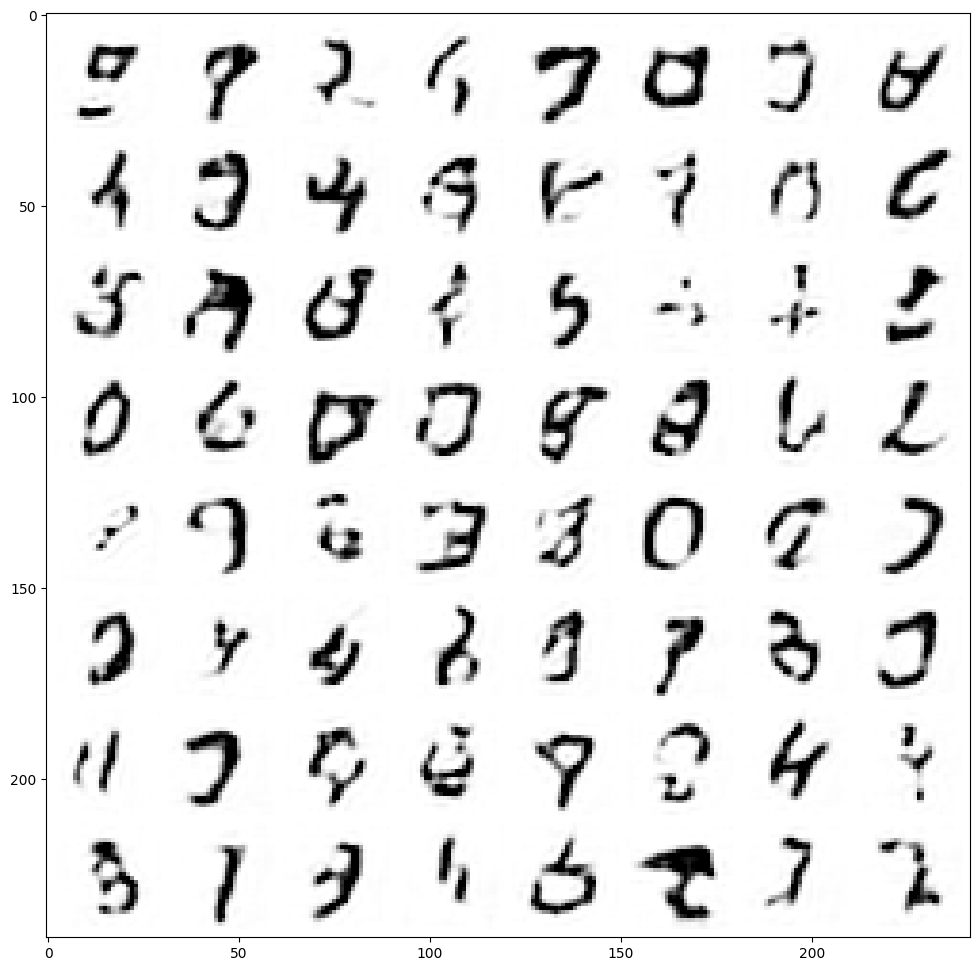

In [14]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1- (i/n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu() , nrow=8)[0].clip(0, 1) , cmap="Greys")


Not great, but there are some recognizable digits there! You can experiment with training for longer (say, 10 or 20 epochs) and tweaking model config, learning rate, optimizer and so on. Also, don’t forget that fashionMNIST is a one-line replacement if you want a slightly harder dataset to try.

# Comparison To DDPM

The diffusers UNet2DModel is a bit more advanced than our BasicUNet
The corruption process in handled differently
The training objective is different, involving predicting the noise rather than the denoised image
The model is conditioned on the amount of noise present via timestep conditioning, where t is passed as an additional argument to the forward method.
There are a number of different sampling strategies available, which should work better than our simplistic version above.

here have been a number of improvements suggested since the DDPM paper came out, but this example is hopefully instructive as to the different available design decisions. Once you’ve read through this, you may enjoy diving into the paper ‘Elucidating the Design Space of Diffusion-Based Generative Models’  : https://arxiv.org/abs/2206.00364


which explores all of these components in some detail and makes new recommendations for how to get the best performance.

If all of this is too technical or intimidating, don’t worry! Feel free to skip the rest of this notebook or save it for a rainy day.

# The UNet
The diffusers UNet2DModel model has a number of improvements over our basic UNet above:

1. GroupNorm applies group normalization to the inputs of each block
2. Dropout layers for smoother training
3. Multiple resnet layers per block (if layers_per_block isn’t set to 1)
4. Attention (usually used only at lower resolution blocks)
5. Conditioning on the timestep.
6. Downsampling and upsampling blocks with learnable parameters

# Let’s create and inspect a UNet2DModel:

In [15]:
model = UNet2DModel(
    sample_size = 28,
    in_channels = 1,
    out_channels = 2,
    layers_per_block = 2,  # how many resnet layers to use  per UNet block
    block_out_channels=(32, 64, 64),  # roughly matching our basic unet example
    down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
    ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [34]:
sum([p.numel() for p in model.parameters()])

1707298

We can replicate the training shown above using this model in place of our original one. We need to pass both x and timestep to the model (here I always pass t=0 to show that it works without this timestep conditioning and to keep the sampling code easy, but you can also try feeding in (amount*1000) to get a timestep equivalent from the corruption amount). Lines changed are shown with #<<< if you want to inspect the code.

Finished epoch 0. Average loss fo this epoch : 0.018650
Finished epoch 1. Average loss fo this epoch : 0.012758
Finished epoch 2. Average loss fo this epoch : 0.011526


Text(0.5, 1.0, 'Generated Samples')

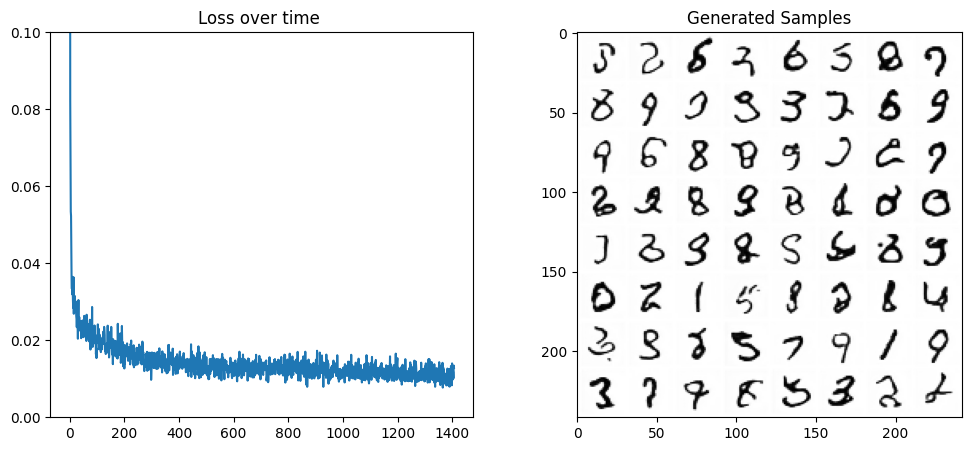

In [17]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size= batch_size, shuffle=True)

n_epochs  = 3

net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)

net.to(device)

loss_fn = nn.MSELoss()

# The optimizer
opt  = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        # get the model prediction
        pred = net(noisy_x, 0).sample

        # Calculate the loss
        loss = loss_fn(pred, x)

        # Backprop and update the params
        opt.zero_grad()
        loss.backward()
        opt.step()


        # store the loss for later
        losses.append(loss.item())


    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss fo this epoch : {avg_loss:05f}")


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time ")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1 - (i / n_steps))  # Starting high going low
    noisy_x = corrupt(x, noise_amount)  # Create our noisy x
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor


axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")


Noise scheduler

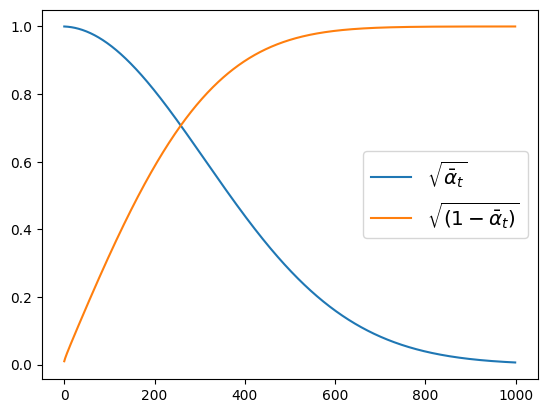

In [19]:
noise_scheduler = DDPMScheduler(num_train_timesteps= 1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu()**0.5 , label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


Text(0.5, 1.0, 'Noisy X')

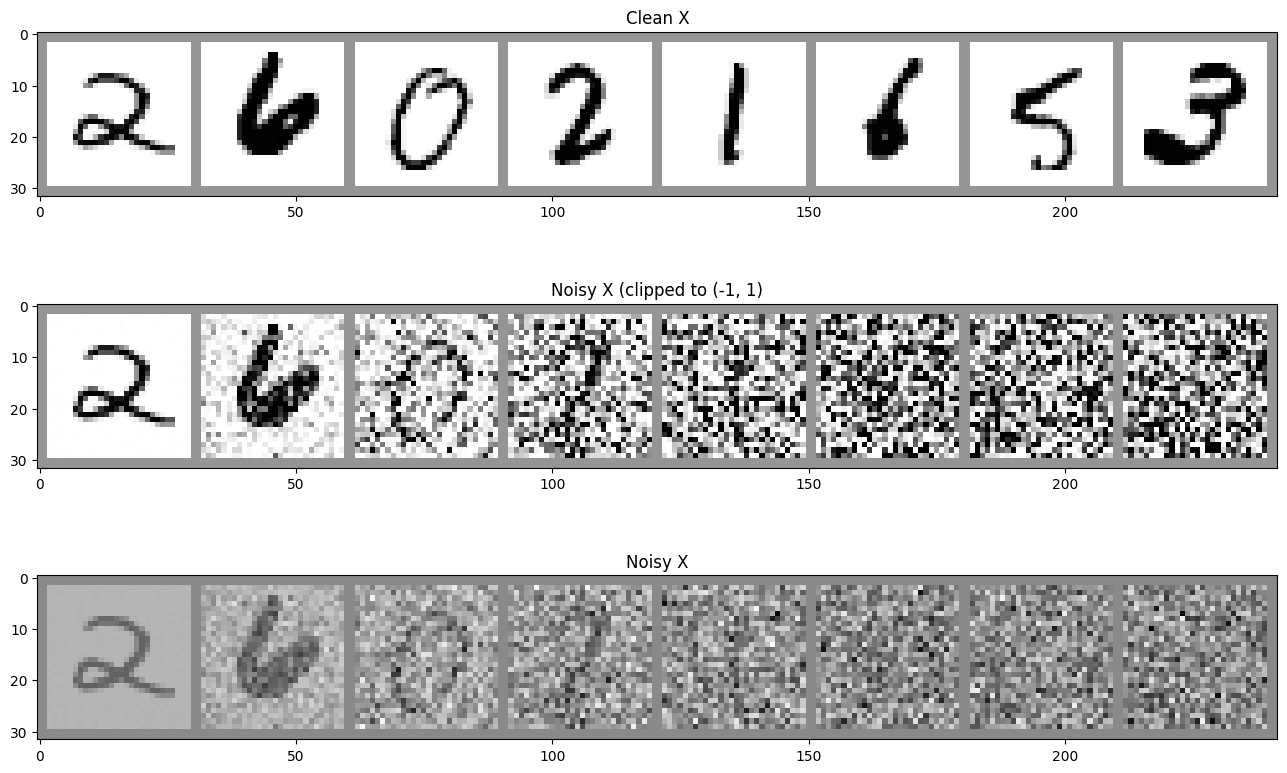

In [20]:
# @markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2.0 - 1.0  # Map to (-1, 1)
print("X shape", xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap="Greys")
axs[0].set_title("Clean X")

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)  # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1), cmap="Greys")
axs[1].set_title("Noisy X (clipped to (-1, 1)")
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap="Greys")
axs[2].set_title("Noisy X")

Another dynamic at play: the DDPM version adds noise drawn from a Gaussian distribution (mean 0, s.d. 1 from torch.randn) rather than the uniform noise between 0 and 1 (from torch.rand) we used in our original corrupt function. In general, it makes sense to normalize the training data as well. In the other notebook, you’ll see Normalize(0.5, 0.5) in the list of transforms, which maps the image data form (0, 1) to (-1, 1) and is ‘good enough’ for our purposes. We didn’t do that for this notebook, but the visualization cell above adds it in for more accurate scaling and visualization.

# Training Objective
In our toy example, we had the model try to predict the denoised image. In DDPM and many other diffusion model implementations, the model predicts the noise used in the corruption process (before scaling, so unit variance noise). In code, it looks something like:

In [33]:
import torch.nn.functional as F
x = x.to(device)

model = model.to(device)
B = x.shape[0]

noise = torch.randn_like(x)

timesteps = torch.randint(
    0,
    noise_scheduler.config.num_train_timesteps,
    (B,),
    device=x.device
).long()


noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

model_prediction = model(noisy_x, timesteps).sample

loss = F.mse_loss(model_prediction, noise)

/tmp/ipython-input-295529439.py:21: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 2, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(model_prediction, noise)
